# Controller and Observer for Quadrotor Drone and Motion Capture System – Harry Zhao

Import libraries

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, interpolate, spatial
import sympy as sym
import ae353_drone

Set print options for printing matrices

In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

## 1. Dynamic Model and Controller Design

**A. Equations of Motion**

The following code block includes the physical parameters of the drone and the calculation of the equations of motion, contained in matrix `f` and which are linearized to create the state-space form of the system. This code is taken from `DeriveEOM.ipynb`.

In [3]:
m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)
f

Matrix([
[                                                     v_x],
[                                                     v_y],
[                                                     v_z],
[                (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                             w_x*sin(psi) + w_y*cos(psi)],
[-w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[                                        2*f_z*sin(theta)],
[                              -2*f_z*sin(phi)*cos(theta)],
[                     2*f_z*cos(phi)*cos(theta) - 981/100],
[                          10000*tau_x/23 - 17*w_y*w_z/23],
[                          10000*tau_y/23 + 17*w_x*w_z/23],
[                                               250*tau_z]])

**B. Linearization**

`f` is linearized to create state matrix `A` and input matrix `B`. `A` is the Jacobian of `f` with respect to the state variables, and `B` is the Jacobian of `f` with respect to the input variables. Equilibrium values for each variable are name with the suffix `_e`. All equilibrium values are zero, with the exception of `f_z_e`, which is chosen to be the weight of the drone. `A` and `B` are intended to satisfy the following relationship.

$$\dot x = Ax + Bu$$

In [4]:
# Equilibrium values
p_x_e = 0.
p_y_e = 0.
p_z_e = 0.
phi_e = 0.
theta_e = 0.
psi_e = 0.
v_x_e = 0.
v_y_e = 0.
v_z_e = 0.
w_x_e = 0.
w_y_e = 0.
w_z_e = 0.
tau_x_e = 0.
tau_y_e = 0.
tau_z_e = 0.
f_z_e = float(m * g)

# Find A and B
A_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, f_z, tau_x, tau_y, tau_z), f.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z]))
A = A_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, f_z_e, tau_x_e, tau_y_e, tau_z_e)
print('\nState Matrix (A)\n')
print(A)

B_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, f_z, tau_x, tau_y, tau_z), f.jacobian([tau_x, tau_y, tau_z, f_z]))
B = B_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, f_z_e, tau_x_e, tau_y_e, tau_z_e)
print('\nInput Matrix (B)\n')
print(B)


State Matrix (A)

[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    1.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.    0.    1.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -9.81  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.   -0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

Input Matrix (B)

[[  0.       0.       0.       0.    ]
 [  0.       0.       

**C. Controllability**

In this section, the system described by `A` and `B` is checked for controllability using the controllability matrix `W`. Should `W` be full rank, the system is controllable. The dimensions and rank of the matrix, as well as the matrix itself, are printed. The controllability matrix is a block matrix as shown below.

$$W = [B \quad AB \quad AB^2 \quad ... \quad A^{n_{x} - 1}]$$

In [5]:
n = A.shape[0]
W = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
rank = np.linalg.matrix_rank(W)
print('\nRank for controllability matrix (W): {}'.format(rank))
print('\nShape of controllability matrix (W): {} x {}\n'.format(W.shape[0], W.shape[1]))
print(W)


Rank for controllability matrix (W): 12

Shape of controllability matrix (W): 12 x 48

[[    0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.      4265.2174     0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.    ]
 [    0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
  -4265.2174     0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.   

**D. Optimal Controller Design**

The infinite horizon LQR problem is solved to minimize the following cost function.

$$\int_{t_0}^{∞} (x(t)^T Q_c x(t) + u(t)^T R_c u(t))\,dt$$

The chosen weight matrices are diagonal matrices, with diagonal values indicated below in the code.

This yields the optimal cost matrix `P`, which is then used to calculate the optimal controller gain matrix `K` with the following formula.

$$K=R_{c}^{-1} B^T P$$

In [6]:
Q_c = np.diag([35, 105, 105, 86, 86, 86, 1, 1, 1, 13, 13, 13])
R_c = np.diag([66, 66, 66, 1])
P = linalg.solve_continuous_are(A, B, Q_c, R_c)
K = linalg.inv(R_c) @  B.T @ P
print('\nGain Matrix (K)\n')
print(np.array2string(K, max_line_width=np.inf))


Gain Matrix (K)

[[-0.     -1.2613  0.      3.0504 -0.     -0.     -0.     -0.8942 -0.      0.4593 -0.     -0.    ]
 [ 0.7282 -0.     -0.      0.      2.646  -0.      0.6387 -0.      0.     -0.      0.4573 -0.    ]
 [-0.      0.      0.     -0.     -0.      1.1415  0.      0.      0.     -0.     -0.      0.454 ]
 [ 0.      0.     10.247  -0.      0.      0.      0.      0.      3.3536 -0.      0.      0.    ]]


**E. Stability**

Examine the eigenvalues of the following equation.

$$A-BK$$

Should all eigenvalues have negative real parts, as shown below, the controller is stable, and the system will converge to equilibrium.

In [7]:
F = A - B @ K
print(F.shape)
p = linalg.eigvals(F)
print(p.tolist())

(12, 12)
[(-1.4452045022901296+1.810665227040146j), (-1.4452045022901296-1.810665227040146j), (-2.999357709291349+0j), (-192.94489081497971+0j), (-192.94489081401093+0j), (-110.92333892034307+0j), (-1.6771050344662681+2.311982614897156j), (-1.6771050344662681-2.311982614897156j), (-3.3536473824717437+3.040879932841743j), (-3.3536473824717437-3.040879932841743j), (-3.417824841955144+0j), (-2.5727307221698124+0j)]


## 2. Sensor Model and Observer Design

**A. Sensor Model**

The sensor model `g` is trivially determined as the available sensor measurements from the motion capture system. These variables are all shared with the state.

In [8]:
g = sym.Matrix([[p_x], [p_y], [p_z], [phi], [theta], [psi]])
g

Matrix([
[  p_x],
[  p_y],
[  p_z],
[  phi],
[theta],
[  psi]])

**B. Linearization**

`g` is linearized to create matrix state-output coefficient matrix `C`. `C` is the Jacobian of `g` with respect to the state variables. `C` is intended to satisfy the following relationship.

$$y=Cx$$

In [9]:
C_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi), g.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z]))
C = C_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e).astype(float)
print('\nState-Output Coefficient Matrix (C)\n')
print(C)


State-Output Coefficient Matrix (C)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


**C. Observability**

This section checks the observability of the system described by `A` and `C` using observability matrix `O`. Should `O` be full rank, the system is observable. The observability matrix is a block matrix as shown below.

$$O = \begin{bmatrix} C \\ CA \\ CA^2 \\ ... \\ CA^{n_{x} - 1} \end{bmatrix}$$

In [10]:
mp = np.linalg.matrix_power
O = np.block([[C], [C @ A], [C @ mp(A, 2)], [C @ mp(A, 3)], [C @ mp(A, 4)], [C @ mp(A, 5)]])
rank = np.linalg.matrix_rank(O)
print('\nRank for observability matrix (O): {}'.format(rank))
print('\nShape of observability matrix (O): {} x {}\n'.format(O.shape[0], O.shape[1]))
print(O)


Rank for observability matrix (O): 12

Shape of observability matrix (O): 36 x 12

[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0

**D. Optimal Observer Design**

The infinite horizon LQR problem is solved to minimize the following cost function.

$$\int_{-∞}^{t_1} (n(t)^T Q_o n(t) + d(t)^T R_o d(t))\,dt$$

The chosen weight matrices are diagonal matrices, with diagonal values indicated below in the code.

This yields the optimal cost matrix `P`, which is then used to calculate the optimal observer gain matrix `L` with the following formula.

$$L=P C^T Q_o$$

In [11]:
Q_o = np.diag([80, 80, 80, 80, 80, 80])
R_o = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
P = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_o), linalg.inv(Q_o))
L = P @ C.T @ Q_o
print('\nObserver gain matrix (L)\n')
print(np.array2string(K, max_line_width=np.inf))


Observer gain matrix (L)

[[-0.     -1.2613  0.      3.0504 -0.     -0.     -0.     -0.8942 -0.      0.4593 -0.     -0.    ]
 [ 0.7282 -0.     -0.      0.      2.646  -0.      0.6387 -0.      0.     -0.      0.4573 -0.    ]
 [-0.      0.      0.     -0.     -0.      1.1415  0.      0.      0.     -0.     -0.      0.454 ]
 [ 0.      0.     10.247  -0.      0.      0.      0.      0.      3.3536 -0.      0.      0.    ]]


**E. Stability**

Examine the eigenvalues of the following equation.

$$A-LC$$

Should all eigenvalues have negative real parts, as shown below, the observer is stable, and the state estimate will converge to the true state.

In [12]:
F = A - L @ C
print(F.shape)
p = linalg.eigvals(F)
print(p.tolist())

(12, 12)
[(-9.400818864279646+0j), (-8.263691684832015+0j), (-1.5283576470248283+0j), (-1.0000636588852265+0j), (-9.400818864279646+0j), (-8.26369168483202+0j), (-1.5283576470248283+0j), (-1.0000636588852292+0j), (-8.887473059269164+0j), (-8.887473059269166+0j), (-1.0063908886531863+0j), (-1.0063908886531872+0j)]


## 3. Controllers

**A. Standard Controller**

This is the base controller, as used for aggregate data collection and which the multiple drone controller builds upon. This is also the framework for the competitive controller entered in the drone race.

The main principles used in this controller are state feedback control with tracking and state estimation using observer design. Below is the formulation for these principles, respectively.

$$u=-K(\hat x - x_{des})$$

$$\hat x(t + \Delta t) = \hat x(t) + \Delta t (A \hat x(t) + Bu(t) - L (C \hat x(t) - y(t)))$$

In [13]:
class RobotController:
    def __init__(self, limiter=None, A=A, B=B, C=C, K=K, L=L, f_z_e=f_z_e):
        self.dt = 0.01
        self.limiter = limiter
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.f_z_e = f_z_e
        self.pos_vector = [2.875, 3.125, 3.125]
        self.ring = None
        self.before = None
        self.after = None
        self.target = None
        

    def get_color(self):
        return np.random.rand(3,).tolist()

    def reset(self, pos):
        self.xhat = np.zeros((12, 1))

    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):     
        
        # Last ring
        if is_last_ring:
            if np.linalg.norm(pos_ring + np.array([0., 0., 1.25]) - pos) > 1.75:
                pos_des = pos_ring + np.array([0., 0., 1.25])
            else:
                pos_des = pos_ring
        # Other rings
        else:
            pos_des = []
            # Get ring data and create offset points
            if not np.array_equal(self.ring, pos_ring):
                self.ring = pos_ring
                self.before = self.ring - np.array([2., 0., 0.])
                self.after = self.ring + np.array([2., 0., 0.])
                self.target = self.before
            # If passed ring
            if pos[0] > pos_ring[0]:
                self.target = self.before
            # Else if close to targeted position
            elif np.linalg.norm(self.target - pos) < 0.75:
                self.target = self.after
            # Set desired point for trajectory tracking
            for i in range(0, pos.shape[0]):
                if np.abs(self.target[i] - self.xhat[i, :].item()) > 0.5 or i == 0:
                    i_des = self.xhat[i, :].item() + self.pos_vector[i] * (self.target[i] - self.xhat[i, :].item()) / np.linalg.norm(self.target - self.xhat[0:3, :].T)
                else:
                    i_des = self.target[i]
                pos_des.append(i_des)

        # Trajectory tracking
        x_des = np.block([[np.array(pos_des), np.zeros(9)]]).T
        u = -self.K @ (self.xhat - x_des)

        tau_x = u[0, 0]
        tau_y = u[1, 0]
        tau_z = u[2, 0]
        f_z = u[3, 0] + self.f_z_e
        
        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)
            u = np.array([[tau_x], [tau_y], [tau_z], [f_z - self.f_z_e]])
        
        y = np.block([[pos, rpy]]).T
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))

        return tau_x, tau_y, tau_z, f_z

**B. Multiple Drone Controller**

This controller inherits from the standard controller, with the additional implementation of code to determine a drone's order and code to enable waiting in `run()` and modifications to `reset()` to accomodate this functionality. This controller framework is used for the cooperative drone race.

In [14]:
class MultiController(RobotController):
    def __init__(self, limiter=None):
        super().__init__(limiter)
        self.counter = 0
        self.wait = 0
        self.order = None
        self.spacing = 2
        
    def reset(self, pos):
        self.counter = 0
        self.order = None
        RobotController.reset(self, pos)
    
    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        
        if self.order is None:
            self.order = 0
            x_pos = pos[0]
            y_pos = pos[1]
            for pos_other in pos_others:
                x_other = pos_other[0]
                y_other = pos_other[1]
                if x_pos < x_other:
                    self.order += 1
                elif x_pos == x_other:
                    if y_pos < y_other:
                        self.order += 1
            self.wait = self.order * self.spacing / self.dt
        
        if self.counter > self.wait:
            tau_x, tau_y, tau_z, f_z = RobotController.run(self, pos, rpy, pos_ring, is_last_ring, pos_others)
        else:
            self.counter += 1
            tau_x, tau_y, tau_z, f_z = 0., 0., 0., 0.
        
        return tau_x, tau_y, tau_z, f_z

**C. Controller Gain Example**

This controller uses identical `Q_c` gains corresponding to x, y, and z positions to create results discussed in the paper.

In [15]:
class KController(RobotController):
    def __init__(self, limiter=None):
        super().__init__(limiter)
        Q_c = np.diag([105, 105, 105, 86, 86, 86, 1, 1, 1, 13, 13, 13])
        P = linalg.solve_continuous_are(A, B, Q_c, R_c)
        self.K = linalg.inv(R_c) @  B.T @ P

**D. Observer Gain Example**

This controller uses lesser `Q_o` gains than the standard controller to create results discussed in the paper.

In [16]:
class LController(RobotController):
    def __init__(self, limiter=None):
        super().__init__(limiter)
        Q_o = np.diag([5, 5, 5, 5, 5, 5])
        P = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_o), linalg.inv(Q_o))
        self.L = P @ C.T @ Q_o

**E. Last Ring Adjustment Example**

This controller lacks an adjustment for the final ring, which is used in the standard controller to reach a point above the center of the ring before landing. Otherwise, it is identical to the standard controller.

In [17]:
class LastController:
    def __init__(self, limiter=None, A=A, B=B, C=C, K=K, L=L, f_z_e=f_z_e):
        self.dt = 0.01
        self.limiter = limiter
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.f_z_e = f_z_e
        self.pos_vector = [2.875, 3.125, 3.125]
        self.ring = None
        self.before = None
        self.after = None
        self.target = None
        

    def get_color(self):
        return np.random.rand(3,).tolist()

    def reset(self, pos):
        self.xhat = np.zeros((12, 1))

    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):     
        
        # Last ring
        if is_last_ring:
            pos_des = pos_ring
        # Other rings
        else:
            pos_des = []
            # Get ring data and create offset points
            if not np.array_equal(self.ring, pos_ring):
                self.ring = pos_ring
                self.before = self.ring - np.array([2., 0., 0.])
                self.after = self.ring + np.array([2., 0., 0.])
                self.target = self.before
            # If passed ring
            if pos[0] > pos_ring[0]:
                self.target = self.before
            # Else if close to targeted position
            elif np.linalg.norm(self.target - pos) < 0.75:
                self.target = self.after
            # Set desired point for trajectory tracking
            for i in range(0, pos.shape[0]):
                if np.abs(self.target[i] - self.xhat[i, :].item()) > 0.5 or i == 0:
                    i_des = self.xhat[i, :].item() + self.pos_vector[i] * (self.target[i] - self.xhat[i, :].item()) / np.linalg.norm(self.target - self.xhat[0:3, :].T)
                else:
                    i_des = self.target[i]
                pos_des.append(i_des)

        # Trajectory tracking
        x_des = np.block([[np.array(pos_des), np.zeros(9)]]).T
        u = -self.K @ (self.xhat - x_des)

        tau_x = u[0, 0]
        tau_y = u[1, 0]
        tau_z = u[2, 0]
        f_z = u[3, 0] + self.f_z_e
        
        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)
            u = np.array([[tau_x], [tau_y], [tau_z], [f_z - self.f_z_e]])
        
        y = np.block([[pos, rpy]]).T
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))

        return tau_x, tau_y, tau_z, f_z

## 4. Results

**A. Simulation for Single Drone Controller**

This performs 200 trials, according to the stipulations of the verification.

In [18]:
simulator = ae353_drone.Simulator(display=False, seed=0)
simulator.add_drone(RobotController, 'drone1', 'harryz2.png')
trials = 200
times = list()
failures = 0

for i in range(trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=60.0)
    if simulator.drones[0]['finish_time'] is not None:
        times.append(simulator.drones[0]['finish_time'])
    else:
        failures += 1
    print('Iterations: {}, Failures: {}'.format(i + 1, failures), end='\r')

simulator.disconnect()

**B. Results and Plot for Single Drone Controller**

The average times and failure rate is calculated, and a histogram is plotted.


Mean finish time: 14.585899999999999
Failure rate: 0.0%



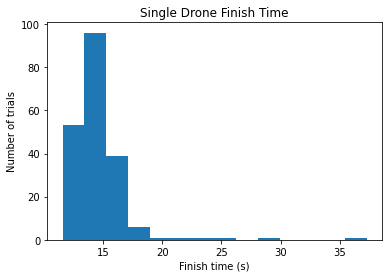

In [19]:
print('\nMean finish time: {}'.format(np.mean(times)))
print('Failure rate: {}%\n'.format(failures / trials * 100))
minimum = np.min(times)
maximum = np.max(times)
bins = np.linspace(minimum, maximum, 15)
plt.hist(times, bins)
plt.title('Single Drone Finish Time')
plt.xlabel('Finish time (s)')
plt.ylabel('Number of trials')
plt.show()

**C. Simulation for Multiple Drone Controller**

Due to the time it takes to simulate more than one drone, this performs 100 trials, following similar stipulations to the verification. The overall finish time is measured as the time of the slowest drone to finish.

In [20]:
simulator = ae353_drone.Simulator(display=False, seed=0)
simulator.add_drone(MultiController, 'drone1', 'harryz2.png')
simulator.add_drone(MultiController, 'drone2', 'harryz2.png')
simulator.add_drone(MultiController, 'drone3', 'harryz2.png')
multi_trials = 100
multi_times = list()
multi_failures = 0

for i in range(multi_trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=60.0)
    drone_times = list()
    for drone in simulator.drones:
        if drone['finish_time'] is not None:
            drone_times.append(drone['finish_time'])
    if len(drone_times) != 3:
        multi_failures += 1
    else:
        multi_times.append(max(drone_times))
    print('Iterations: {}, Failures: {}'.format(i + 1, multi_failures), end='\r')

simulator.disconnect()

**D. Results and Plot for Multiple Drone Controller**

The average times and failure rate is calculated, and a histogram is plotted.


Mean finish time: 18.213368421052635
Failure rate: 5.0%



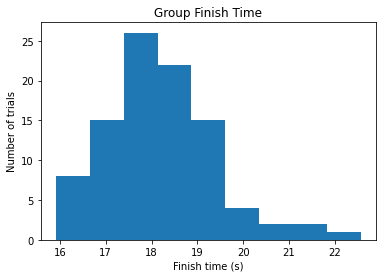

In [21]:
print('\nMean finish time: {}'.format(np.mean(multi_times)))
print('Failure rate: {}%\n'.format(multi_failures / multi_trials * 100))
minimum = np.min(multi_times)
maximum = np.max(multi_times)
bins = np.linspace(minimum, maximum, 10)
plt.hist(multi_times, bins)
plt.title('Group Finish Time')
plt.xlabel('Finish time (s)')
plt.ylabel('Number of trials')
plt.show()

**E. Failure Case 1: Simulation and Results for Different Controller Gains**

This is the same as the verification simulation, just with an older (worse) controller version.

Iterations: 200, Failures: 39
Mean finish time: 14.293416149068321
Failure rate: 19.5%



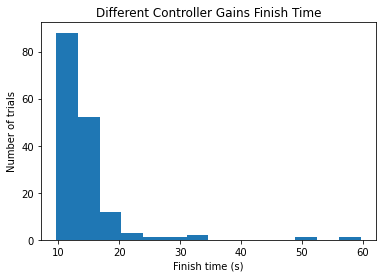

In [22]:
simulator = ae353_drone.Simulator(display=False, seed=0)
simulator.add_drone(KController, 'drone1', 'harryz2.png')
K_trials = 200
K_times = list()
K_failures = 0

for i in range(K_trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=60.0)
    if simulator.drones[0]['finish_time'] is not None:
        K_times.append(simulator.drones[0]['finish_time'])
    else:
        K_failures += 1
    print('Iterations: {}, Failures: {}'.format(i + 1, K_failures), end='\r')

simulator.disconnect()

print('\nMean finish time: {}'.format(np.mean(K_times)))
print('Failure rate: {}%\n'.format(K_failures / K_trials * 100))
minimum = np.min(K_times)
maximum = np.max(K_times)
bins = np.linspace(minimum, maximum, 15)
plt.hist(K_times, bins)
plt.title('Different Controller Gains Finish Time')
plt.xlabel('Finish time (s)')
plt.ylabel('Number of trials')
plt.show()

**F. Failure Case 2: Simulation and Results for Different Observer Gains**

This is the same as the verification simulation, just with an older (worse) observer version.

Iterations: 200, Failures: 73
Mean finish time: 21.69433070866142
Failure rate: 36.5%



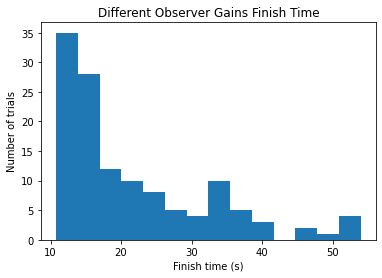

In [23]:
simulator = ae353_drone.Simulator(display=False, seed=0)
simulator.add_drone(LController, 'drone1', 'harryz2.png')
L_trials = 200
L_times = list()
L_failures = 0

for i in range(L_trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=60.0)
    if simulator.drones[0]['finish_time'] is not None:
        L_times.append(simulator.drones[0]['finish_time'])
    else:
        L_failures += 1
    print('Iterations: {}, Failures: {}'.format(i + 1, L_failures), end='\r')

simulator.disconnect()

print('\nMean finish time: {}'.format(np.mean(L_times)))
print('Failure rate: {}%\n'.format(L_failures / L_trials * 100))
minimum = np.min(L_times)
maximum = np.max(L_times)
bins = np.linspace(minimum, maximum, 15)
plt.hist(L_times, bins)
plt.title('Different Observer Gains Finish Time')
plt.xlabel('Finish time (s)')
plt.ylabel('Number of trials')
plt.show()

**G. Failure Case 3: Simulation and Results Without Last Ring Adjustment**

The following code runs the verification to measure failure rate without the last ring adjustment.

In [24]:
simulator = ae353_drone.Simulator(display=False, seed=0)
simulator.add_drone(LastController, 'drone1', 'harryz2.png')
last_trials = 200
last_times = list()
last_failures = 0

for i in range(last_trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=60.0)
    if simulator.drones[0]['finish_time'] is not None:
        last_times.append(simulator.drones[0]['finish_time'])
    else:
        last_failures += 1
    print('Iterations: {}, Failures: {}'.format(i + 1, last_failures), end='\r')

simulator.disconnect()

print('\nMean finish time: {}'.format(np.mean(last_times)))
print('Failure rate: {}%\n'.format(last_failures / last_trials * 100))

Iterations: 200, Failures: 184
Mean finish time: 13.69
Failure rate: 92.0%



**H. Video**

The following code runs the simulation shown in the video for this submission.

In [ ]:
simulator = ae353_drone.Simulator(display=True, seed=0)
simulator.add_drone(MultiController, 'drone1', 'harryz2.png')
simulator.camera_droneview('drone1')
simulator.reset()
simulator.run(max_time=60.0)
simulator.add_drone(MultiController, 'drone2', 'harryz2.png')
simulator.add_drone(MultiController, 'drone3', 'harryz2.png')
simulator.camera_startview()
simulator.reset()
simulator.run(max_time=60.0)
simulator.clear_drones()